# Темпоральные графовые нейронные сети

In [1]:
import torch

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def set_seed():
    """
    Задает стартовое значение генератора псевдослучайных
    чисел для воспроизводимости.
    """
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)

## Прогнозирование веб-трафика

2024-02-15 15:10:05.379730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


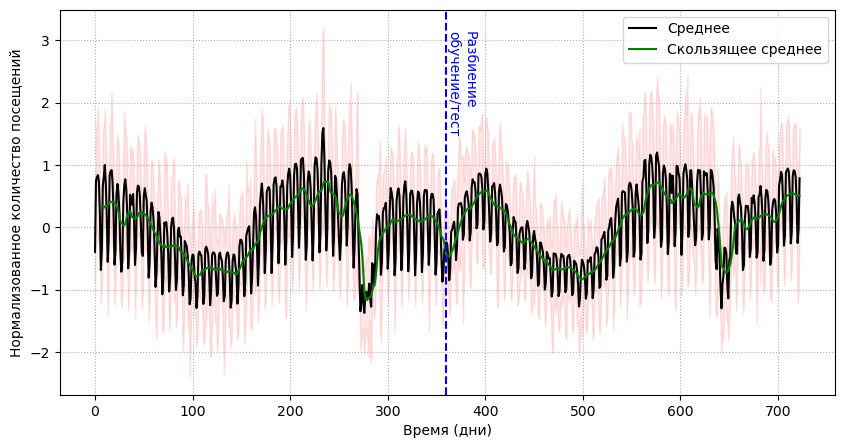

In [2]:
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = WikiMathsDatasetLoader().get_dataset()
train_dataset, test_dataset = temporal_signal_split(
    dataset, train_ratio=0.5
)

mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
df['rolling'] = df['mean'].rolling(7).mean()
                         
plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-', label='Среднее')
plt.plot(df['rolling'], 'g-', label='Скользящее среднее')
plt.grid(linestyle=':')
plt.fill_between(df.index, 
                 df['mean'] - df['std'], 
                 df['mean'] + df['std'], 
                 color='r', 
                 alpha=0.1)

plt.axvline(x=360, color='b', linestyle='--')

plt.text(360, 1.5, 'Разбиение\nобучение/тест', 
         rotation=-90, color='b')

plt.xlabel('Время (дни)')
plt.ylabel('Нормализованное количество посещений')
plt.legend(loc='upper right');

In [3]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.linear = torch.nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(dataset[0].x.shape[0], dataset[0].x.shape[1])
model

TemporalGNN(
  (recurrent): EvolveGCNH(
    (pooling_layer): TopKPooling(8, ratio=0.00749063670411985, multiplier=1.0)
    (recurrent_layer): GRU(8, 8)
    (conv_layer): GCNConv_Fixed_W(8, 8)
  )
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

In [4]:
set_seed()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

# Обучение
for epoch in tqdm(range(50)):
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, 
                       snapshot.edge_index, 
                       snapshot.edge_attr)
        loss = torch.mean((y_pred-snapshot.y)**2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Оценка
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, 
                   snapshot.edge_index, 
                   snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE = {loss.item():.4f}')

100%|███████████████████████████████████████████| 50/50 [08:08<00:00,  9.77s/it]


MSE = 0.7676


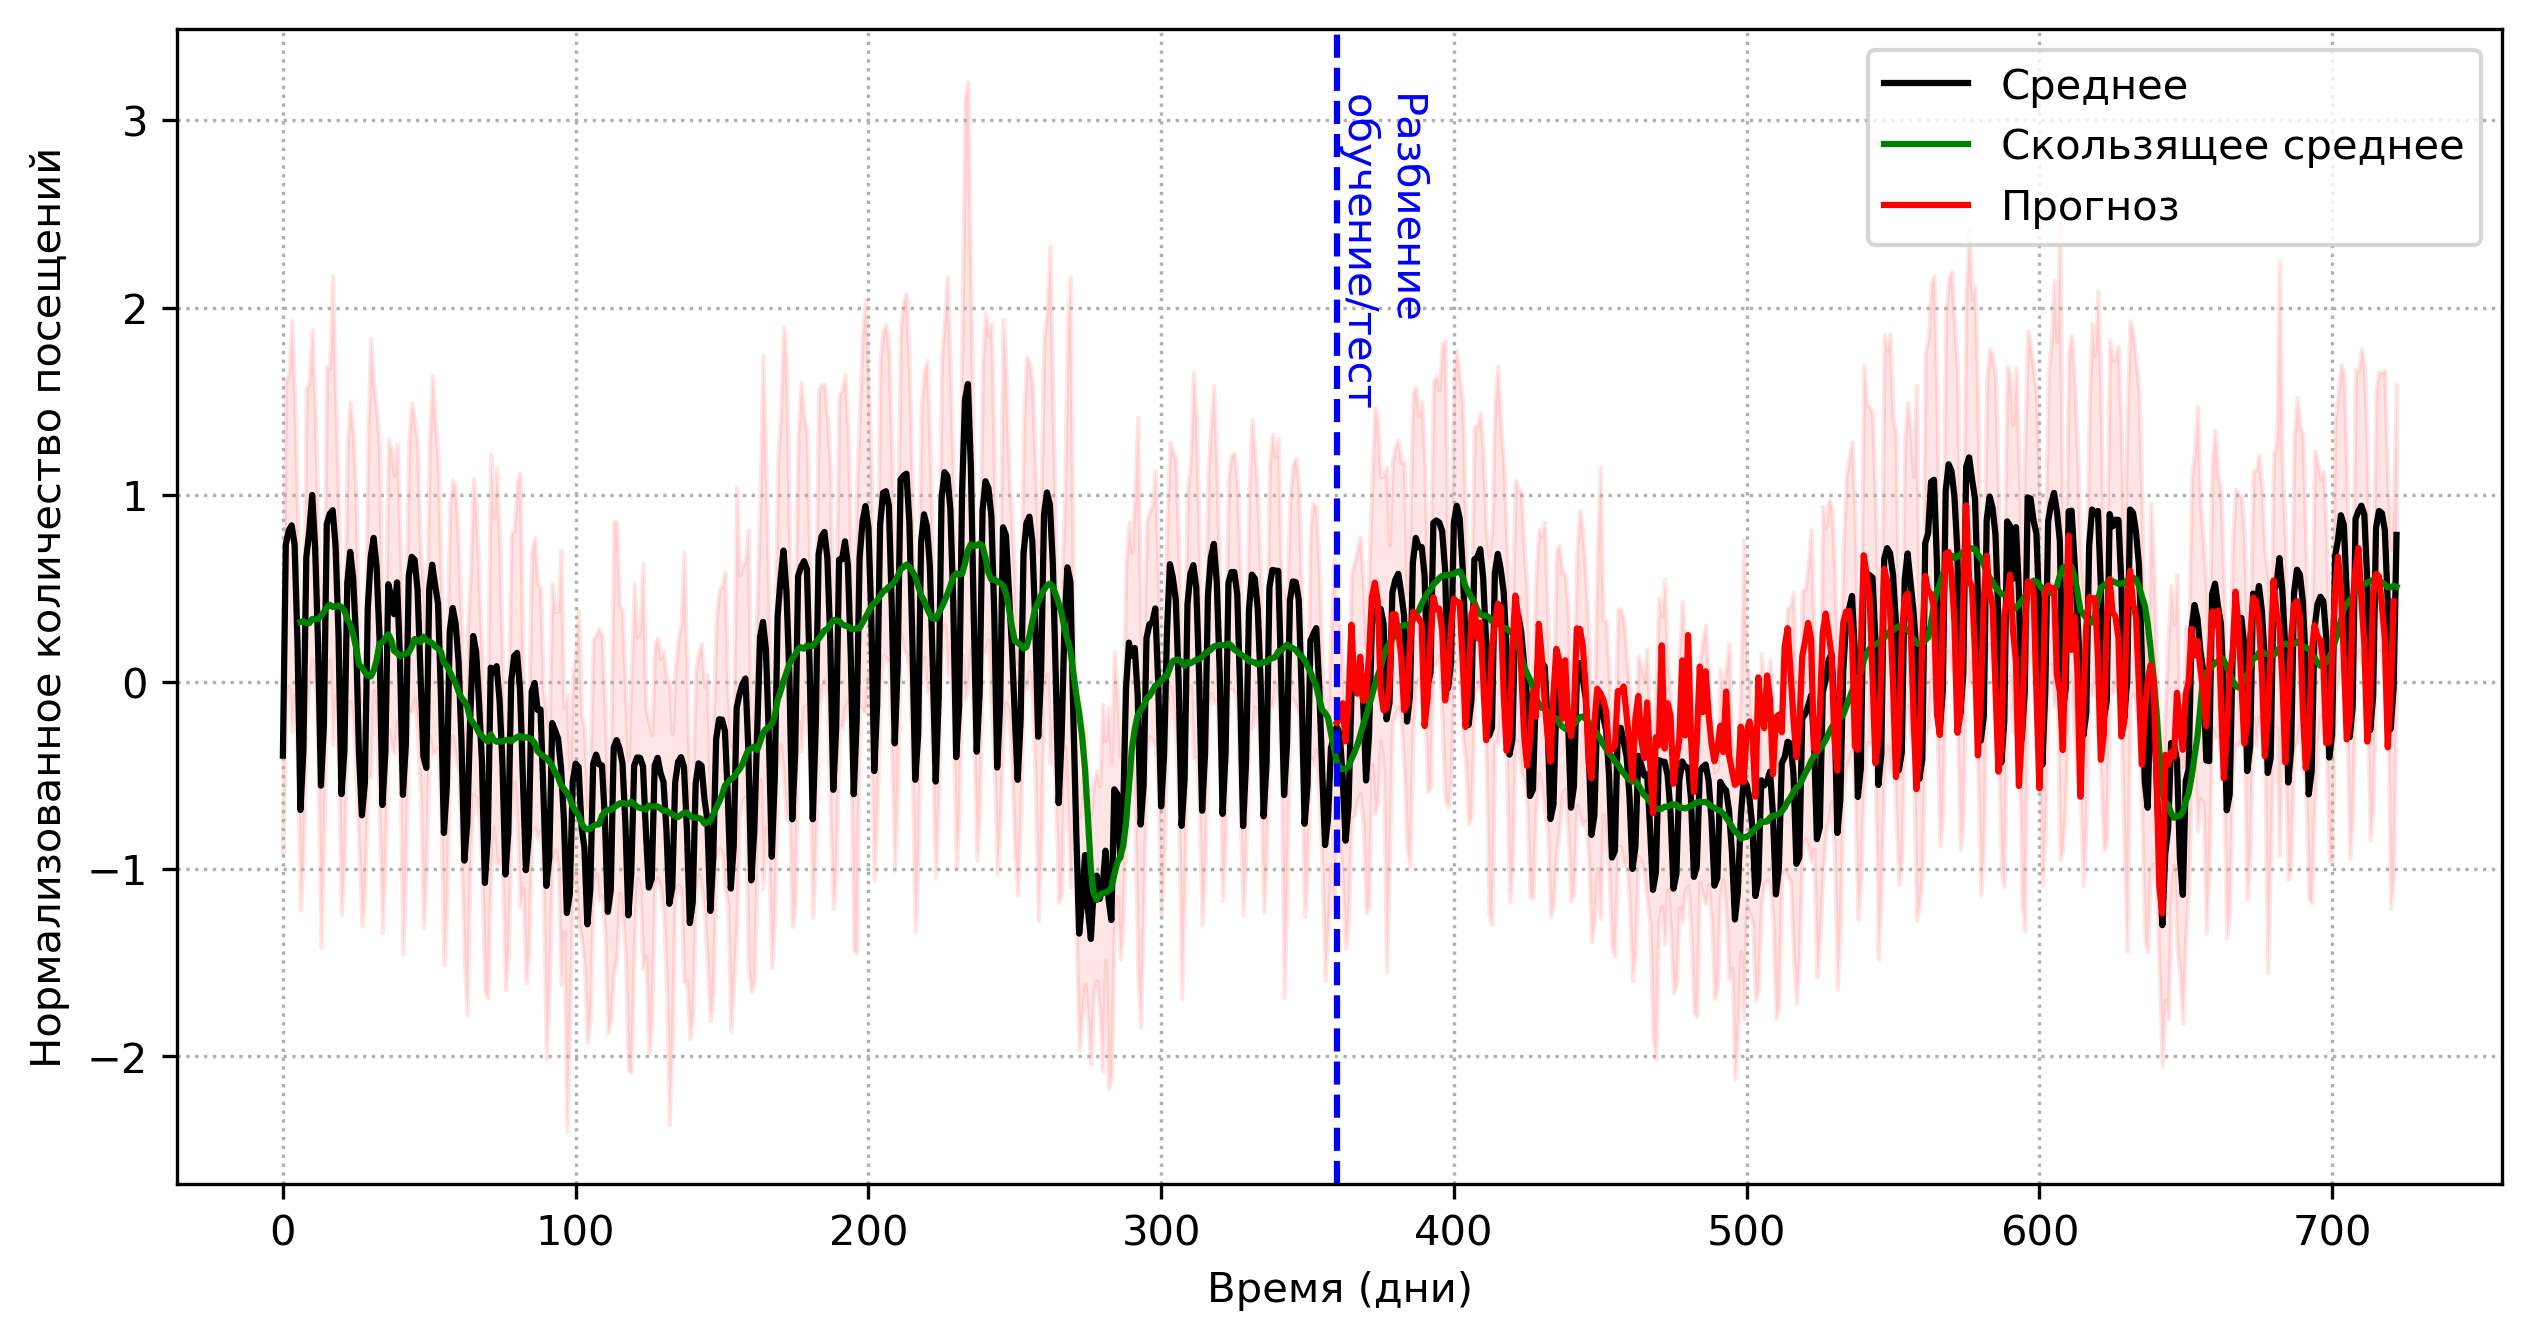

In [5]:
y_preds = [
    model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    .squeeze()
    .detach()
    .numpy()
    .mean() for snapshot in test_dataset
]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-', label='Среднее')
plt.plot(df['rolling'], 'g-', label='Скользящее среднее')
plt.plot(range(360,722), y_preds, 'r-', label='Прогноз')
plt.grid(linestyle=':')
plt.fill_between(df.index, 
                 df['mean'] - df['std'], 
                 df['mean'] + df['std'], 
                 color='r', 
                 alpha=0.1)

plt.axvline(x=360, color='b', linestyle='--')

plt.text(360, 1.5, 'Разбиение\nобучение/тест', 
         rotation=-90, color='b')

plt.xlabel('Время (дни)')
plt.ylabel('Нормализованное количество посещений')
plt.legend(loc='upper right');

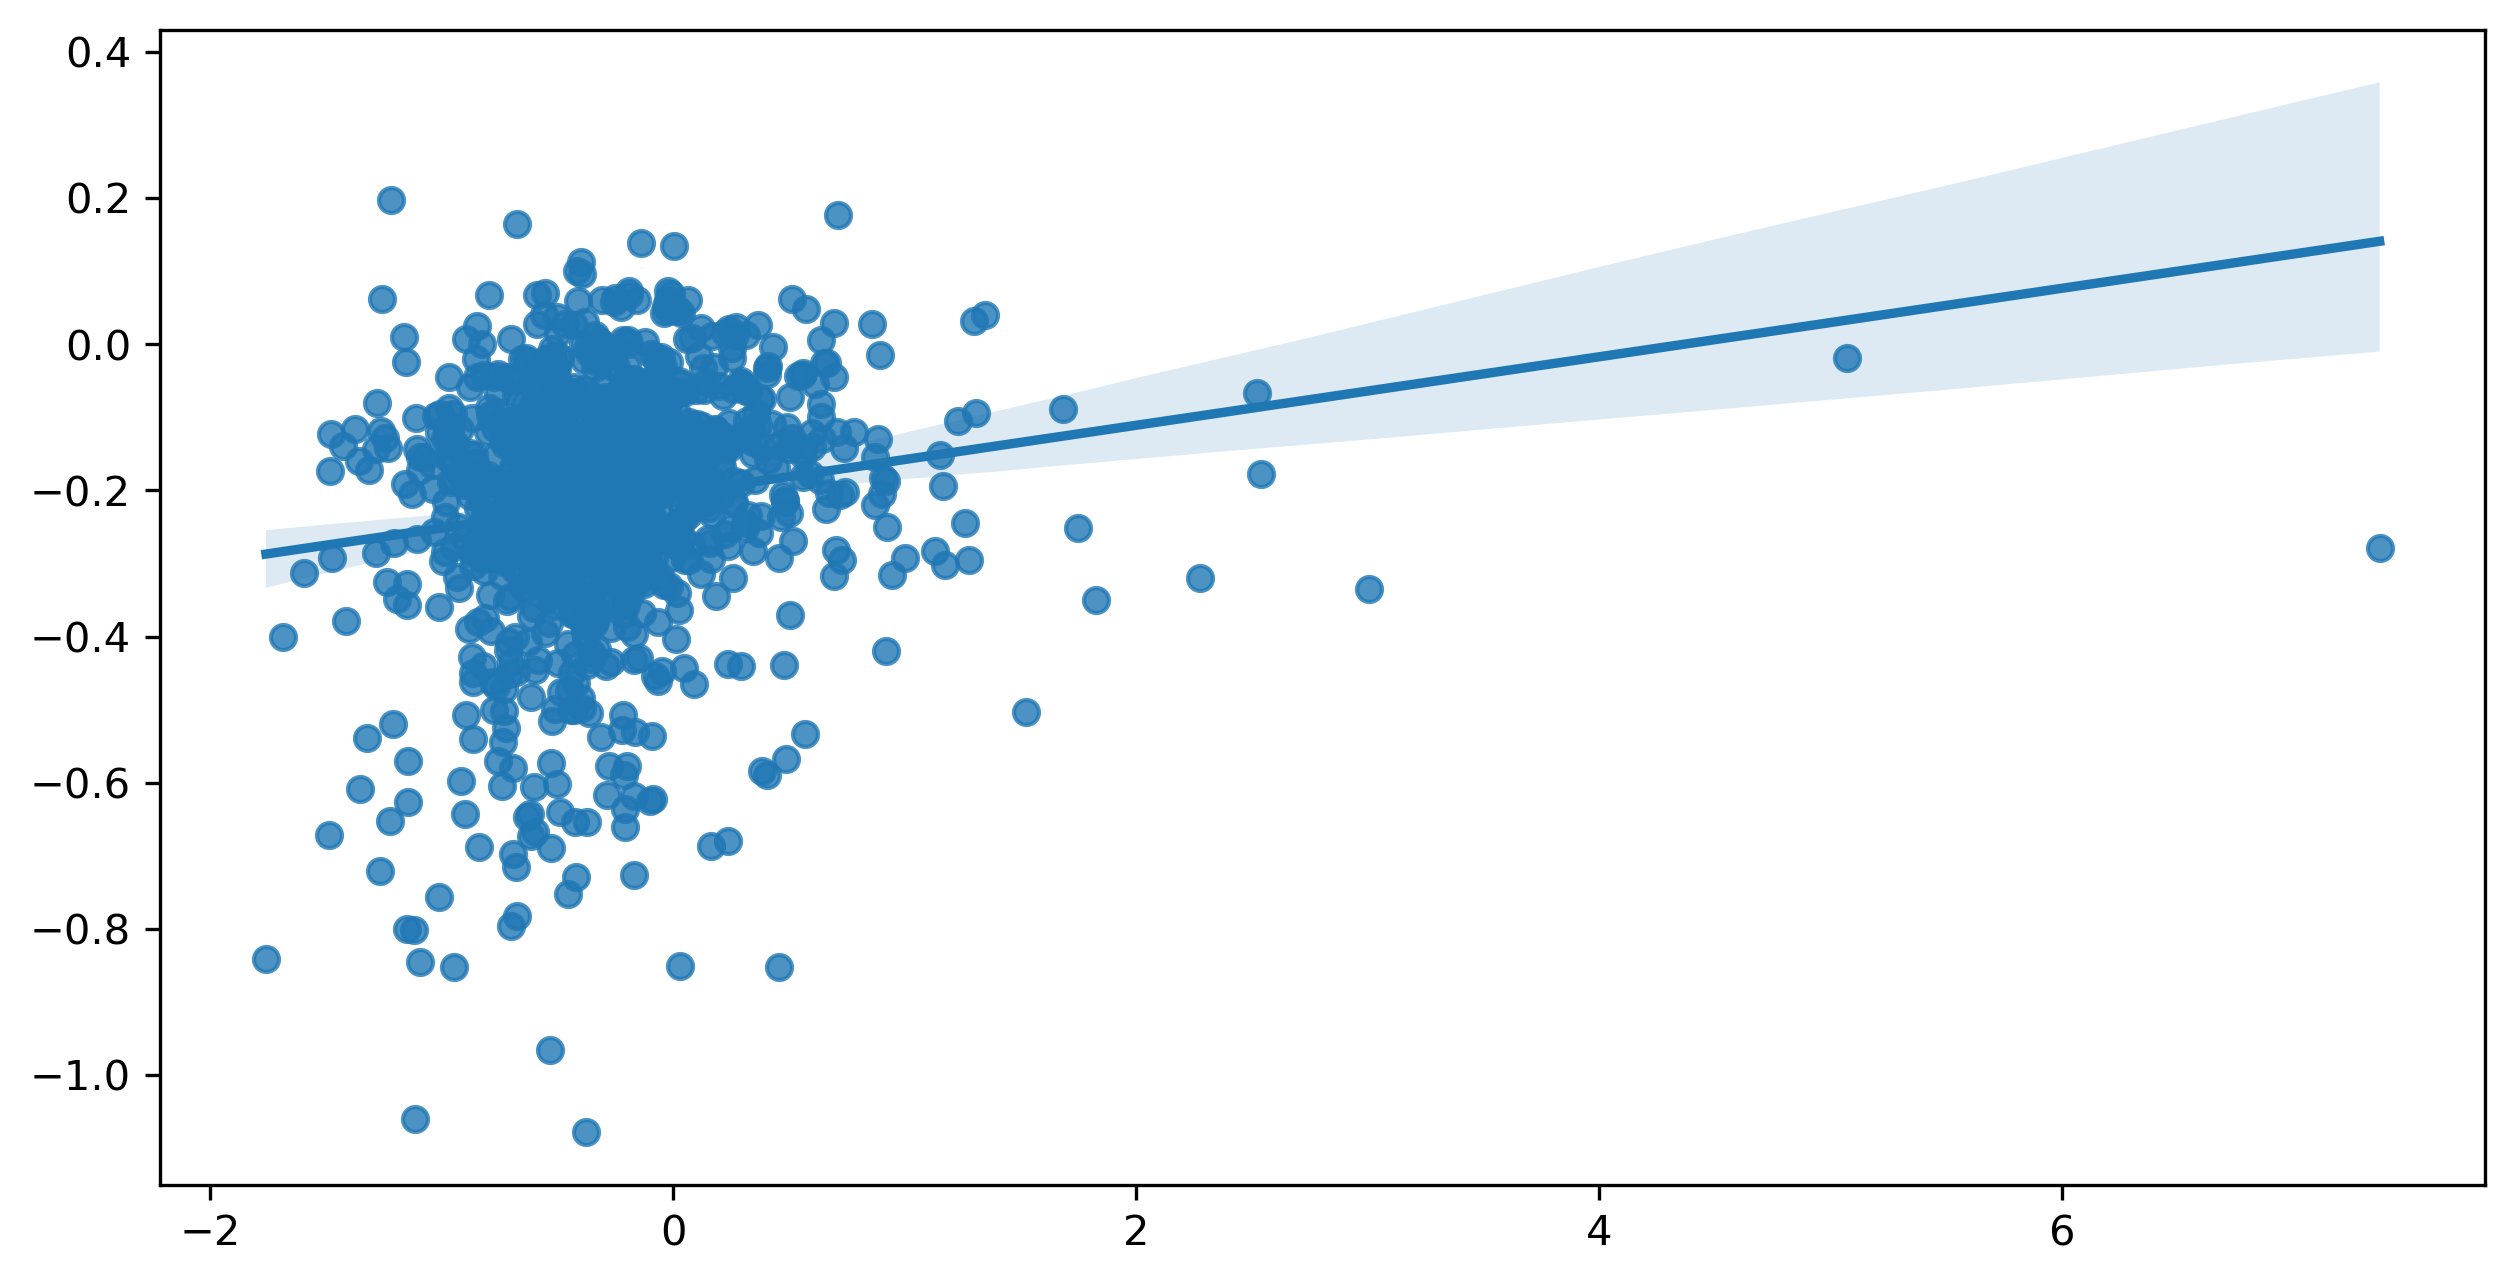

In [6]:
import seaborn as sns

y_pred = (
    model(test_dataset[0].x, 
          test_dataset[0].edge_index, 
          test_dataset[0].edge_attr)
    .detach()
    .squeeze()
    .numpy()
)

plt.figure(figsize=(10,5), dpi=300)
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred);

In [7]:
from torch_geometric_temporal.nn.recurrent import EvolveGCNO

class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNO(dim_in, 1)
        self.linear = torch.nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(dataset[0].x.shape[1])

## Прогнозирование количества случаев COVID-19

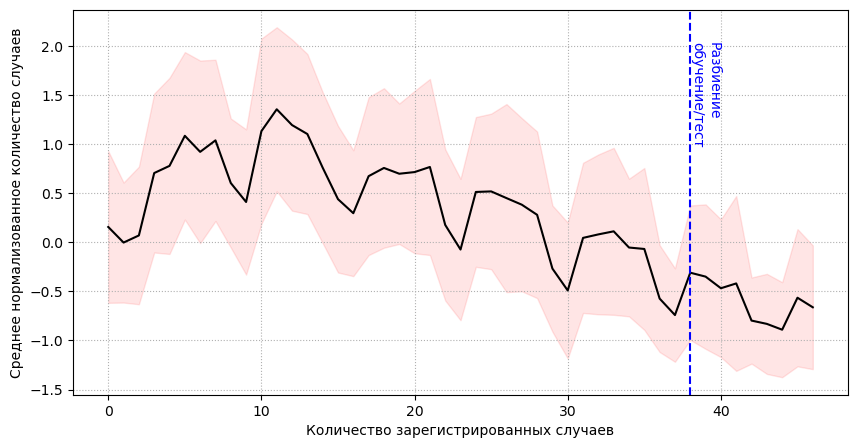

In [8]:
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader

dataset = EnglandCovidDatasetLoader().get_dataset(lags=14)
train_dataset, test_dataset = temporal_signal_split(dataset, 
                                                    train_ratio=0.8)

mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
                         
plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-')
plt.grid(linestyle=':')
plt.fill_between(df.index, 
                 df['mean'] - df['std'], 
                 df['mean'] + df['std'], 
                 color='r', 
                 alpha=0.1)

plt.axvline(x=38, color='b', linestyle='--', 
            label='Разбиение\nобучение/тест')

plt.text(38, 1, 'Разбиение\nобучение/тест', 
         rotation=-90, color='b')

plt.xlabel('Количество зарегистрированных случаев')
plt.ylabel('Среднее нормализованное количество случаев');

In [9]:
from torch_geometric_temporal.nn.recurrent import MPNNLSTM

class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, num_nodes):
        super().__init__()
        self.recurrent = MPNNLSTM(dim_in, dim_h, num_nodes, 1, 0.5)
        self.dropout = torch.nn.Dropout(0.5)
        self.linear = torch.nn.Linear(2*dim_h + dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.dropout(h)
        h = self.linear(h).tanh()
        return h

model = TemporalGNN(dataset[0].x.shape[1], 
                    64, 
                    dataset[0].x.shape[0])
model

TemporalGNN(
  (recurrent): MPNNLSTM(
    (_convolution_1): GCNConv(14, 64)
    (_convolution_2): GCNConv(64, 64)
    (_batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_recurrent_1): LSTM(128, 64)
    (_recurrent_2): LSTM(64, 64)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=142, out_features=1, bias=True)
)

In [10]:
set_seed()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

# Обучение
for epoch in tqdm(range(100)):
    loss = 0
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, 
                       snapshot.edge_index, 
                       snapshot.edge_attr)
        loss = loss + torch.mean((y_pred-snapshot.y)**2)
    loss = loss / (i+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Оценка
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, 
                   snapshot.edge_index, 
                   snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE: {loss.item():.4f}')

100%|█████████████████████████████████████████| 100/100 [00:50<00:00,  1.96it/s]

MSE: 1.5005


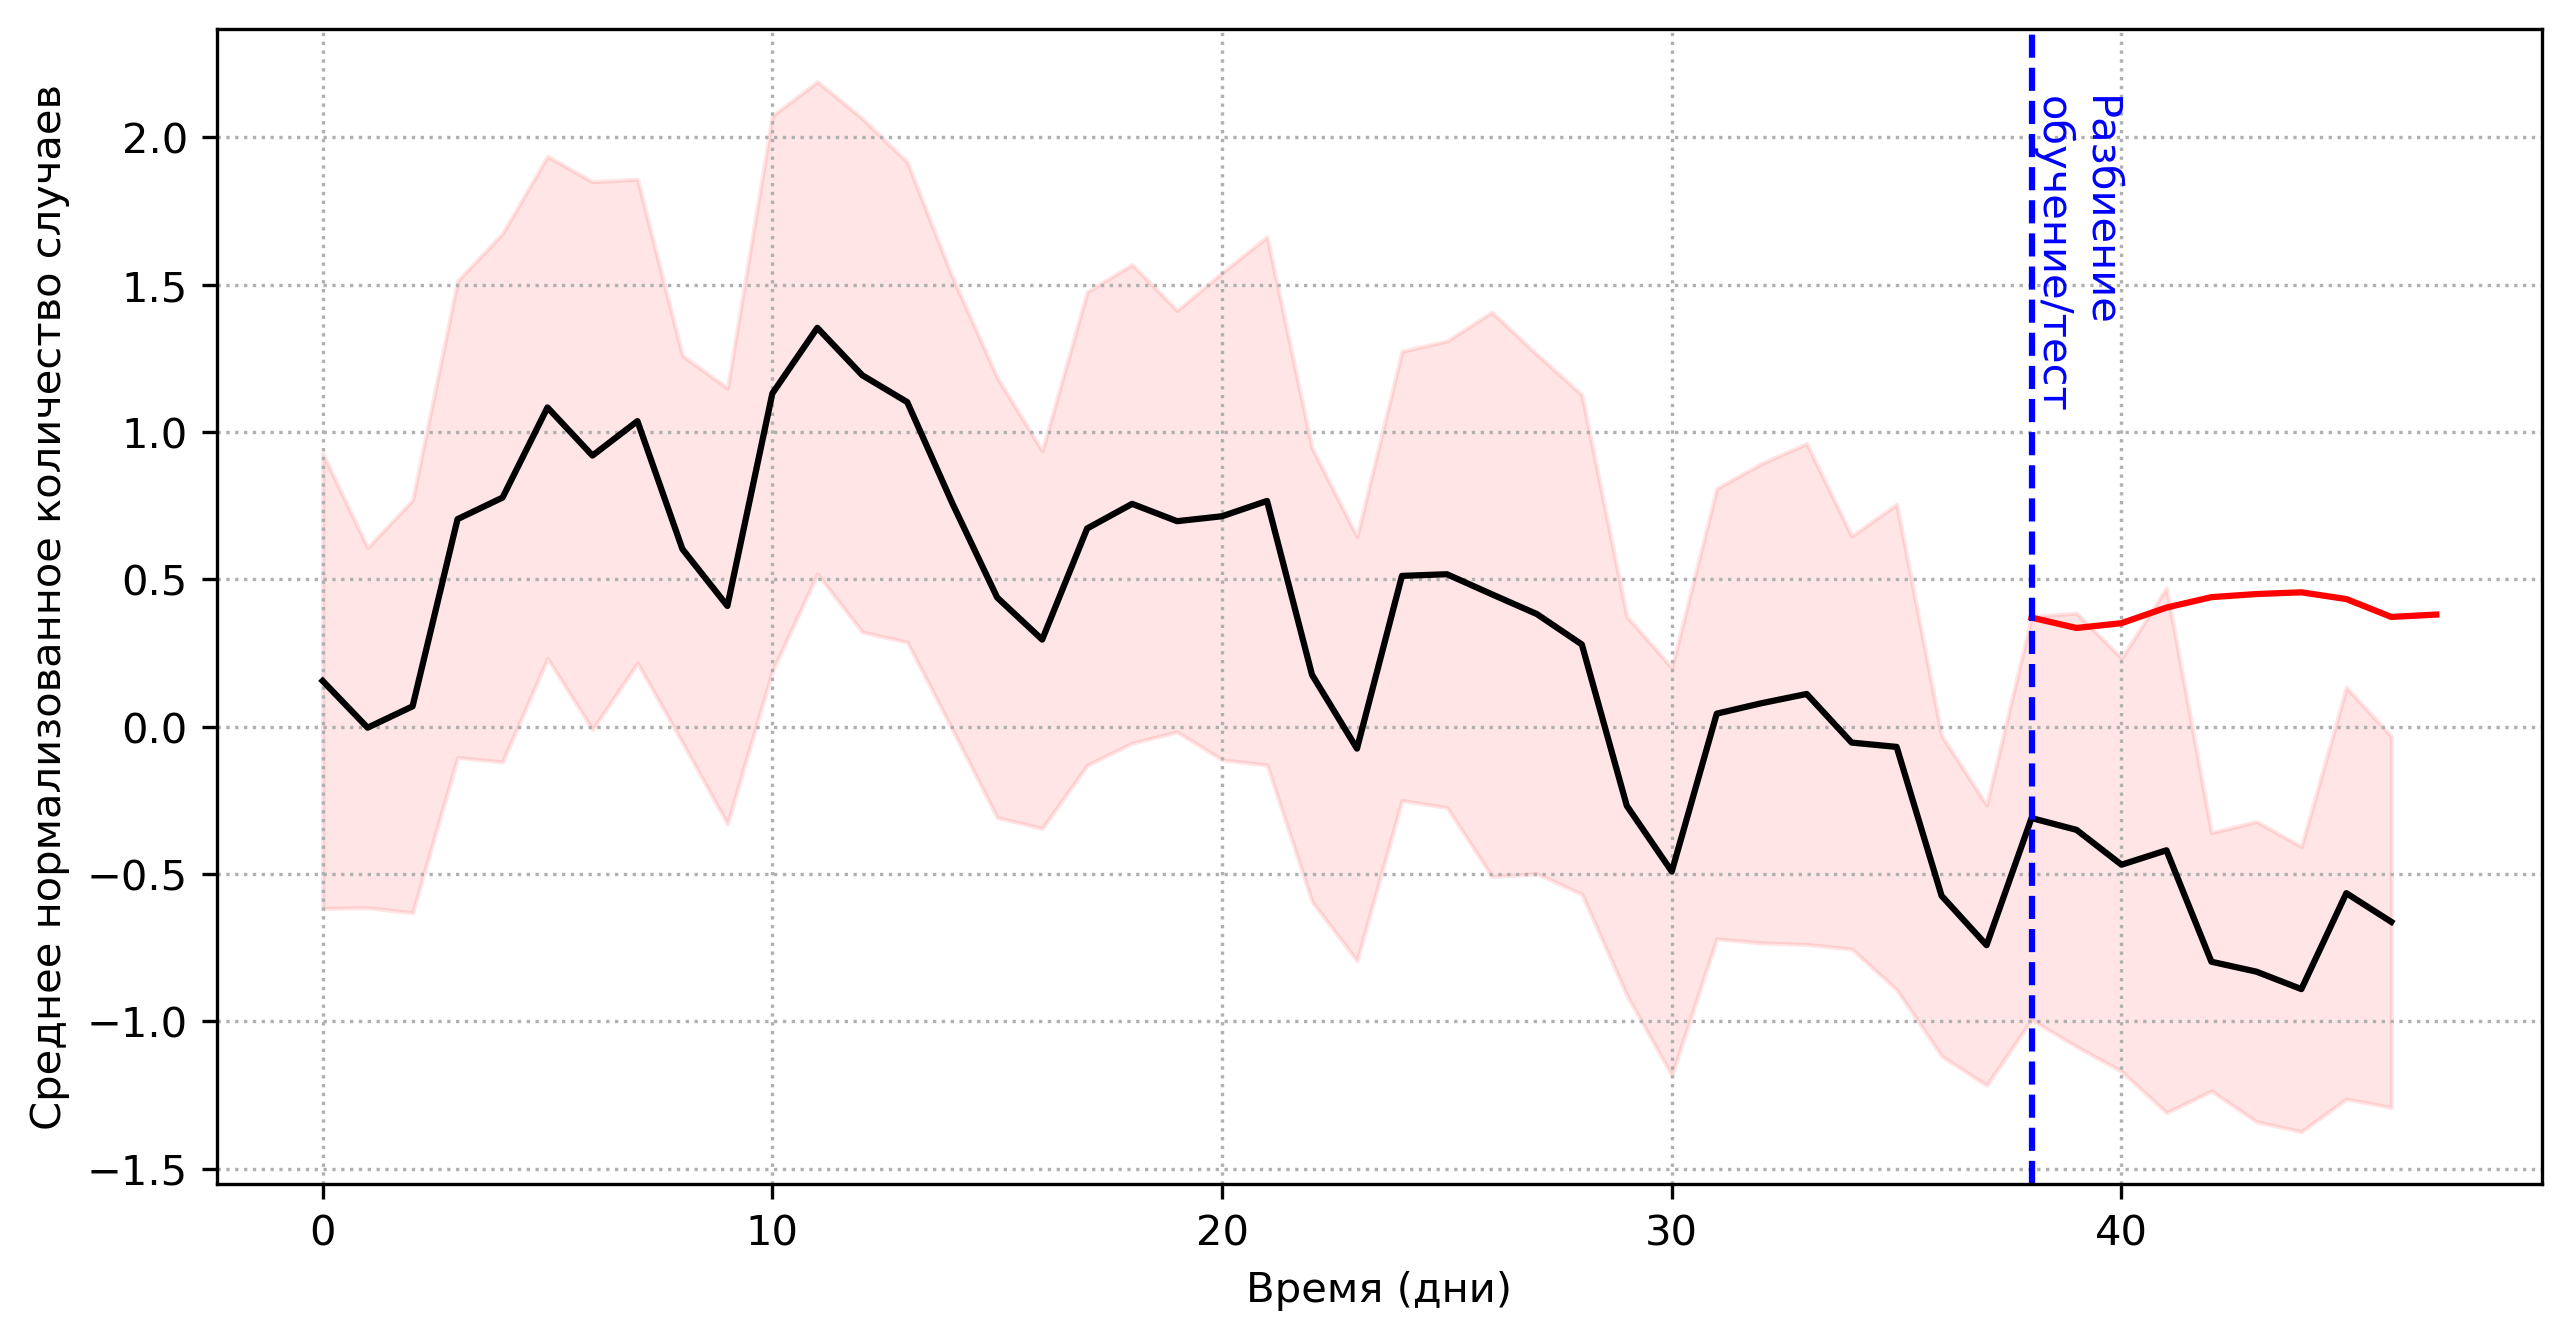

In [11]:
y_preds = [
    model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    .squeeze()
    .detach()
    .numpy()
    .mean() for snapshot in test_dataset
]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-')
plt.plot(range(38,48), y_preds, 'r-', label='Прогноз')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean'] - df['std'], 
                 df['mean'] + df['std'], 
                 color='r', 
                 alpha=0.1)

plt.axvline(x=38, color='b', linestyle='--', 
            label='Разбиение\nобучение/тест')

plt.text(38, 1.1, 'Разбиение\nобучение/тест', 
         rotation=-90, color='b')

plt.xlabel('Время (дни)')
plt.ylabel('Среднее нормализованное количество случаев');

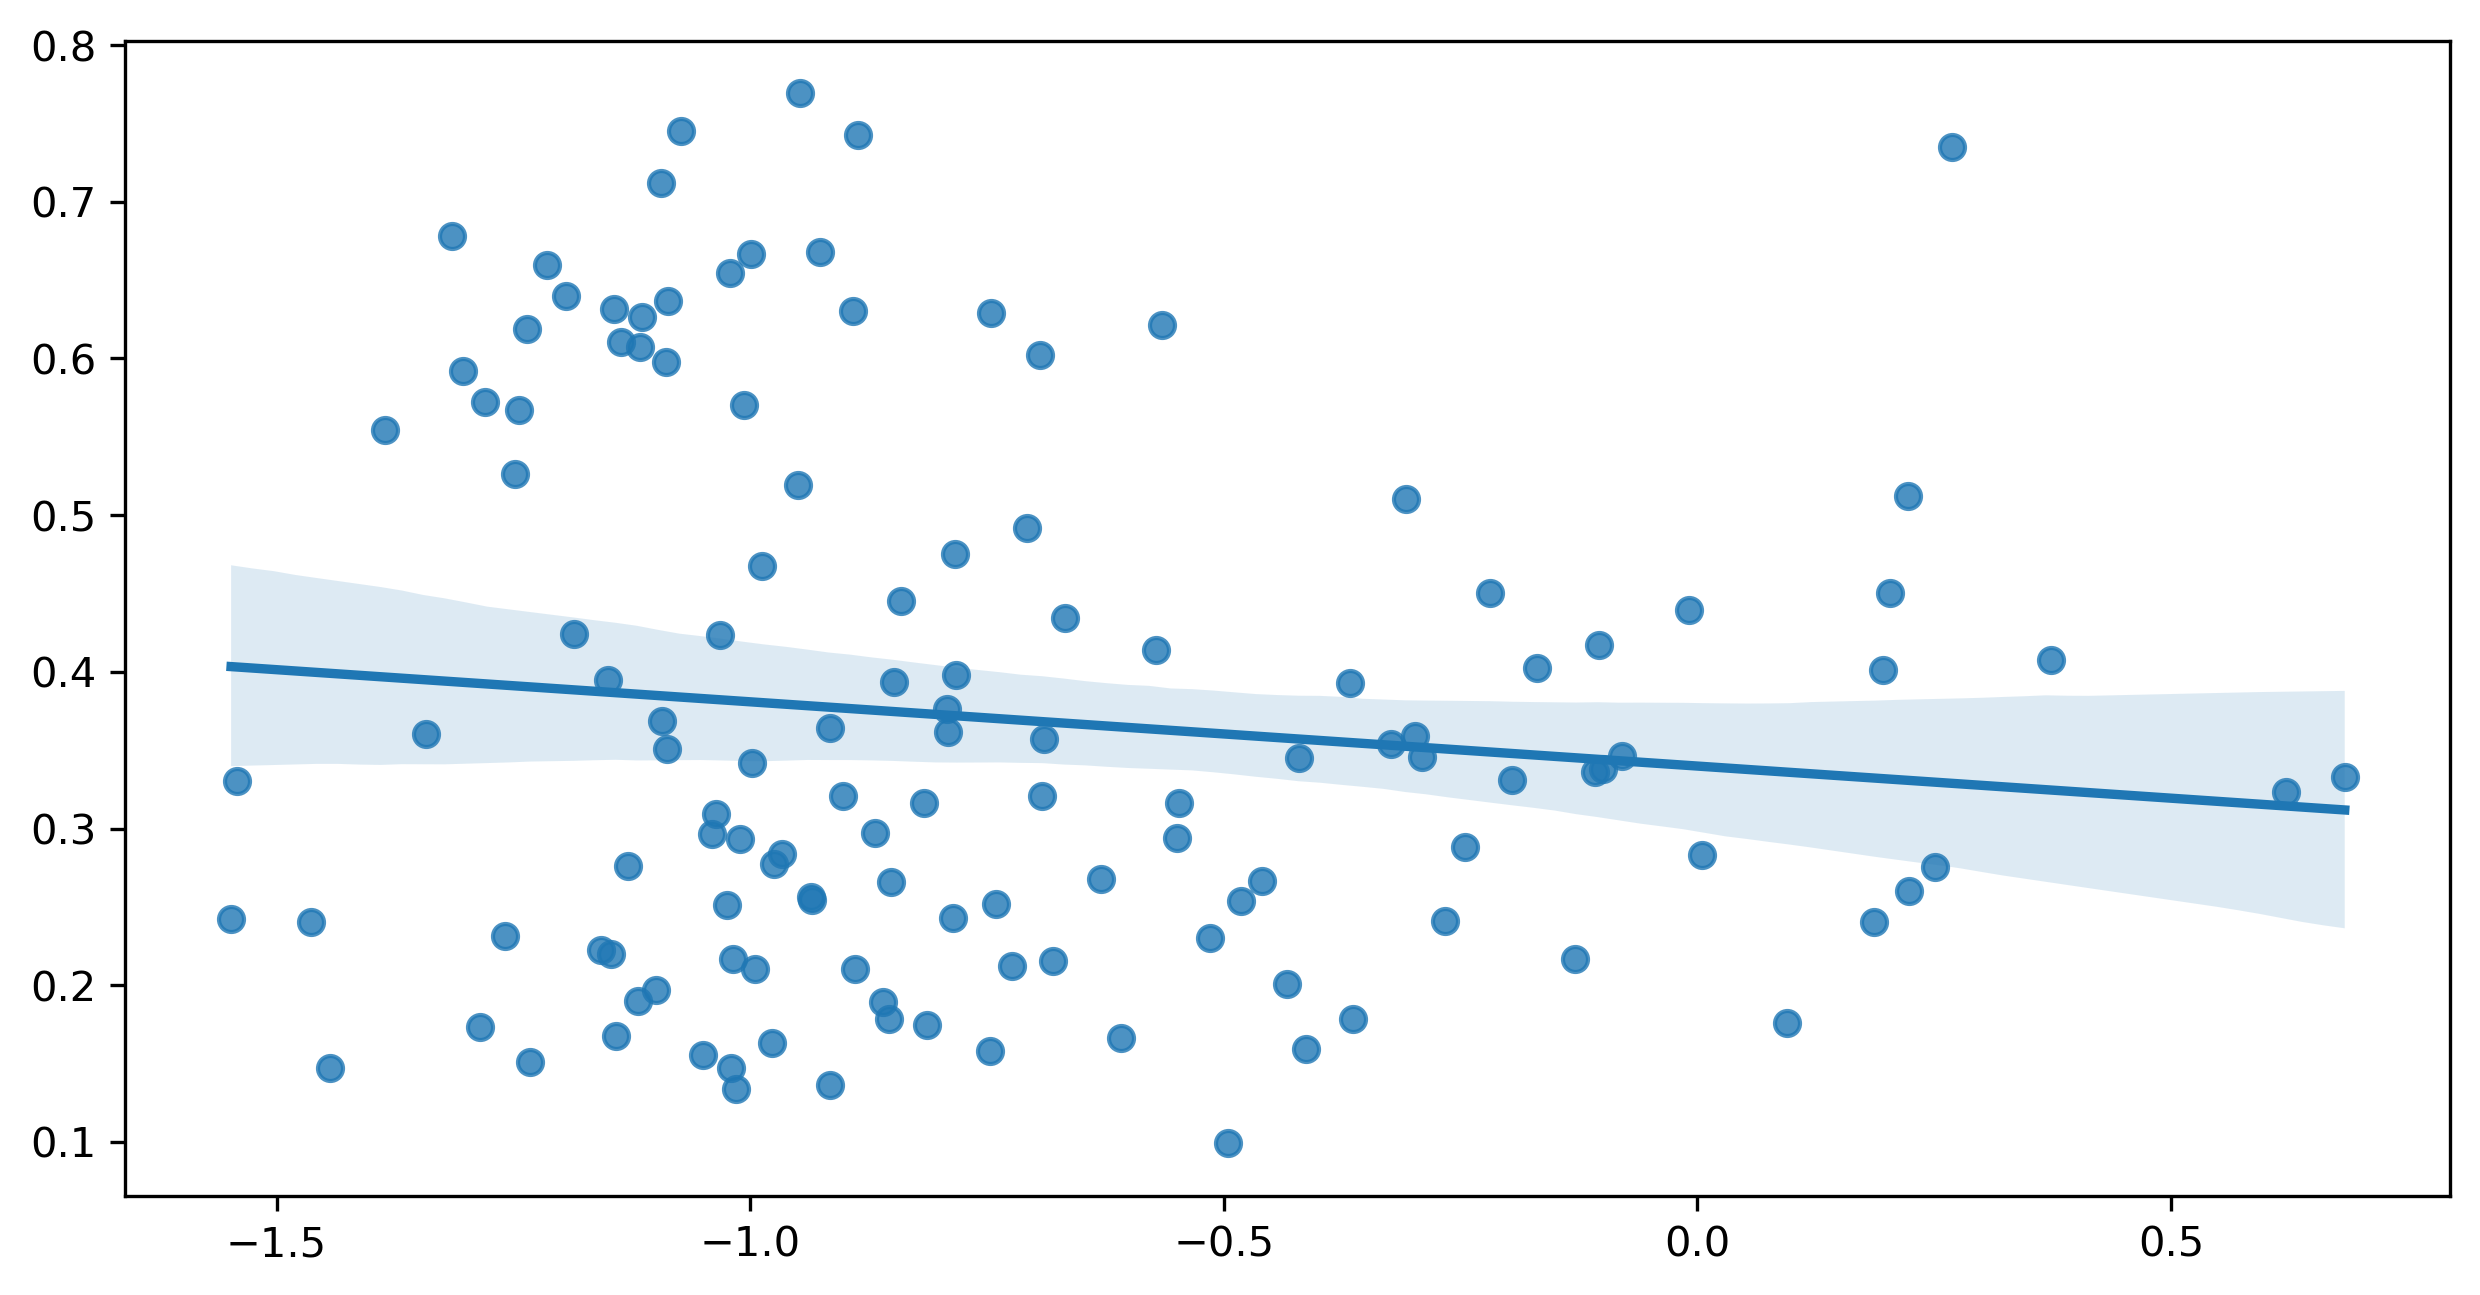

In [12]:
import seaborn as sns

y_pred = (
    model(test_dataset[0].x, 
          test_dataset[0].edge_index, 
          test_dataset[0].edge_attr)
    .detach()
    .squeeze()
    .numpy()
)

plt.figure(figsize=(10,5), dpi=300)
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred);